In [1]:
import pandas as pd
import numpy  as np

import pickle
 
from pathlib import Path


import statsmodels.api as sm

import matplotlib.pyplot as plt


import sys
sys.path.append("D:/analyze_Pearson_residuals")

from  plot_tab_utilities import *



pd.set_option('display.max_columns', 5)

In [2]:
#### user specified
data_folder = r"D:/analyze_Pearson_residuals/"

data_subfolder = "Macosko_GEO"

data_path = Path ( data_folder + data_subfolder )

In [3]:
# output plots
Ag_plot_jpg = data_subfolder + "_Figure_2.jpg"
Lg_plot_jpg = data_subfolder + "_Figure_4.jpg"  
Sg_plot_jpg = data_subfolder + "_Figure_6.jpg"


# input data
nru_dict_pkl =  "nru_dict.pkl"
scanpy_variance_pkl = "residual_variance_scanpy.pkl"
SCT_variance_pkl = "SCT_v2_residual_variance.pkl"
Ag_complementary_pkl = "Ag_complementary_samples.pkl"
Lg_complementary_pkl = "Lg_complementary_samples.pkl"
Sg_complementary_pkl = "Sg_complementary_samples.pkl"
 


# paths: output plots
Ag_plot_dsn = data_path / Ag_plot_jpg
Lg_plot_dsn = data_path / Lg_plot_jpg
Sg_plot_dsn = data_path / Sg_plot_jpg

# paths: input data
nru_dict_dsn = data_path / nru_dict_pkl
scanpy_variance_dsn = data_path / scanpy_variance_pkl
SCT_variance_dsn = data_path / SCT_variance_pkl
Ag_complementary_dsn = data_path / Ag_complementary_pkl
Lg_complementary_dsn = data_path / Lg_complementary_pkl
Sg_complementary_dsn = data_path / Sg_complementary_pkl

In [4]:
def plot_tab ( df_analy, method_symbol, method_label, plot_jpg_dsn ):

  df_analy['ratio'] = df_analy[1]/ df_analy[0]
  df_analy['abs_log_ratio'] = np.abs ( np.log10 ( df_analy['ratio'] ) ) 
 
  df_analy['rank_stat'] = df_analy['stat'].rank ( ascending=False )
  df_analy['rank_0'] = df_analy[0].rank ( ascending=False )
  df_analy['rank_1'] = df_analy[1].rank ( ascending=False )

  df_analy['group_0'] = pd.cut ( df_analy['rank_0'], bins, labels=labels )
  df_analy['group_1']   = pd.cut ( df_analy['rank_1'], bins, labels=labels )
 
  xtab_in = df_analy.rename( columns={'group_0':'S', 'group_1':'S_tilde'} )
  pti = pv_table_noprint_margins ( xtab_in, 'S', 'S_tilde' )


  rank_stat_200 = df_analy['stat'].loc [ df_analy['rank_stat'] == 200 ].max()
  print (  '\n\n genes rank_stat_200: ', rank_stat_200 )  

  arr_unreliability = df_analy['unreliability'].values
  x = np.log10 ( arr_unreliability )
  y = df_analy['abs_log_ratio'].values

  x = sm.add_constant(x)  
  result = sm.OLS(y, x).fit()
  print( '\n\n', result.summary() )

  max_unreliability = np.max ( arr_unreliability )
  max_log10_unreliability = np.log10 ( max_unreliability )  
  ypred_x_max = result.predict( [1, max_log10_unreliability] )
  ypred_x_min = result.predict( [1, 0] )
 
  fig, (ax1, ax2, ax3 )  = plt.subplots(1,3, figsize=( 8., 3. ) )

  plot_ax ( df_analy, ax1, 'A', 0, 1, 'sample S', 'sample $\~S$'  )
  
  plot_ax ( df_analy, ax2, 'B', 'stat', 'abs_log_ratio', method_label, 'abs ( log$_1$$_0$ ( ' + method_symbol + '($\~S$) / ' + method_symbol + '(S) ) )' , yscale_log=False, line_slope='none' )
  ax2.axvline ( rank_stat_200,  linewidth=1, color='red') 
  y_min2, y_max2 = ax2.get_ylim()

  plot_ax ( df_analy, ax3, 'C', 'unreliability', 'abs_log_ratio', 'unreliability ratio: ' + "$M_g$" + '/' + "$A_g$", \
  'abs ( log$_1$$_0$ ( ' + method_symbol + '($\~S$) / ' + method_symbol + '(S) ) )' , yscale_log=False, line_slope='none' )
  ax3.plot ( [ 1, max_unreliability ], [ ypred_x_min, ypred_x_max ], linewidth=1, color='red')  
  y_min3, y_max3 = ax3.get_ylim()   
 
  y_min = min ( y_min2, y_min3 )
  y_max = max ( y_max2, y_max3 )
  ax2.set_ylim ( y_min, y_max )
  ax3.set_ylim ( y_min, y_max ) 
    
    
  plt.subplots_adjust( wspace=0.3, bottom=0.2 )
  plt.savefig(  plot_jpg_dsn, transparent=True, dpi=300 )  
    
  return pti

In [5]:
pctl_list = [.01,.05, .10, .25, .5, .75, .90, .95, .99 ]


bins = [ 0, 20, 50, 100, 200, 500, 2000, 1e6]
labels = ['1-20', '21-50', '51-100', '101-200', '201-500','501-2000', '2001+']

In [6]:
f = open( nru_dict_dsn, 'rb' )    
nru_dict = pickle.load(f)           
f.close()       


df_unreliability = nru_dict['df_gene_stats'] [['A_g', 'M_g']]
df_unreliability = df_unreliability.assign( unreliability = df_unreliability['M_g'] / df_unreliability['A_g'] )
print ( ' df_unreliability:  ' )
print ( '\n', df_unreliability )
print ( '\n\n df_unreliability.describe' )
print ( df_unreliability[['unreliability']].describe ( percentiles=pctl_list ) )


df_A_g = nru_dict['df_gene_stats'] [['A_g']].rename( columns={'A_g':'stat'} )
print ( '\n\n df_A_g:  ' )
print ( '\n', df_A_g )

 
df_L_g = pd.read_pickle ( scanpy_variance_dsn )[['CLIPPED']].rename( columns={'CLIPPED':'stat'} )
print ( '\n\n df_L_g:  ' )
print ( '\n', df_L_g )


df_S_g = pd.read_pickle ( SCT_variance_dsn ).rename( columns={'residual_variance':'stat'} )
print ( '\n\n df_S_g:  ' )
print ( '\n', df_S_g )

 df_unreliability:  

                      A_g        M_g  unreliability
CARTPT         42.740254  50.106662       1.172353
RGS5           17.483289  21.950167       1.255494
RHO            15.539177  15.911165       1.023939
APOE           14.865133  16.349967       1.099887
GLUL           14.769975  15.349501       1.039237
...                  ...        ...            ...
RTN4R           0.337634   0.553451       1.639203
GM25749         0.337634   0.425641       1.260658
KIF26B          0.337634   0.504799       1.495106
A330033J07RIK   0.337634   0.337634       1.000000
RHOV            0.337634   0.390722       1.157236

[13552 rows x 3 columns]


 df_unreliability.describe
       unreliability
count   13552.000000
mean        1.155433
std         0.674932
min         1.000000
1%          1.027422
5%          1.038533
10%         1.046953
25%         1.067128
50%         1.105452
75%         1.182560
90%         1.303994
95%         1.397956
99%         1.664087
max        77.56


  A_g


 df_complementary_stats_Ag

                 0          1
CARTPT  42.555279  34.216827
RGS5    18.789861  13.142684
APOE    15.425091  13.912950
RHO     14.919805  15.568703
GLUL    14.640142  14.538062
...           ...        ...
KCNQ3    0.469762   0.563198
EFNA5    0.469762   0.456927
BTBD11   0.469762   0.507167
CCNE1    0.469762   0.550283
MRAP2    0.469762   0.456733

[12082 rows x 2 columns]


 genes rank_stat_200:  2.179528904993944


                             OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.152
Model:                            OLS   Adj. R-squared:                  0.152
Method:                 Least Squares   F-statistic:                     2159.
Date:                Tue, 11 Jul 2023   Prob (F-statistic):               0.00
Time:                        08:15:20   Log-Likelihood:                 25576.
No. Observations:               12082   AIC:                        

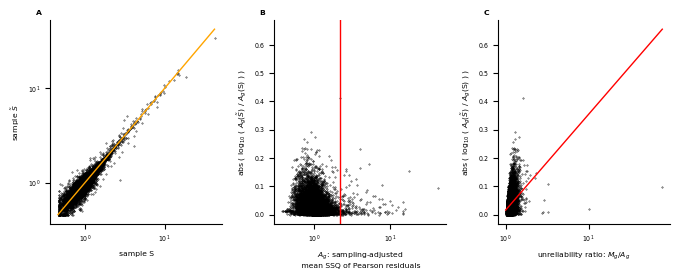

In [7]:
print ( '\n  A_g' )  
df_complementary_stats_Ag = pd.read_pickle ( Ag_complementary_dsn )  
print ( '\n\n df_complementary_stats_Ag' )
print ( '\n', df_complementary_stats_Ag )  

df_A_g_UR = pd.concat ( [ df_A_g[['stat']], df_unreliability[['unreliability']] ], axis=1 )
df_stats_Ag = df_A_g_UR.merge ( df_complementary_stats_Ag, how='inner', left_index=True, right_index=True )
pti = plot_tab ( df_stats_Ag, "$A_g$", '$A_g$: sampling-adjusted \n mean SSQ of Pearson residuals',  Ag_plot_dsn ) 
print ( '\n\n Table 3' )
pd.set_option('display.max_columns', 8)
print ( '\n', pti )  
pd.set_option('display.max_columns', 5)


  L_g


 df_complementary_stats_Lg

                    0          1
CARTPT     34.868703  28.818525
RGS5       21.454272  16.127682
APOE       17.131418  15.826166
GLUL       15.464545  14.996507
MT-RNR2    14.496866  13.857703
...              ...        ...
IL34        0.501279   0.455905
SLC41A3     0.499102   0.690357
FABP3-PS1   0.489785   0.475354
SHB         0.486703   0.570099
GM26906     0.469195   0.619259

[12082 rows x 2 columns]


 genes rank_stat_200:  2.3951928879762976


                             OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.254
Model:                            OLS   Adj. R-squared:                  0.254
Method:                 Least Squares   F-statistic:                     4110.
Date:                Tue, 11 Jul 2023   Prob (F-statistic):               0.00
Time:                        08:15:36   Log-Likelihood:                 25620.
No. Observations:              

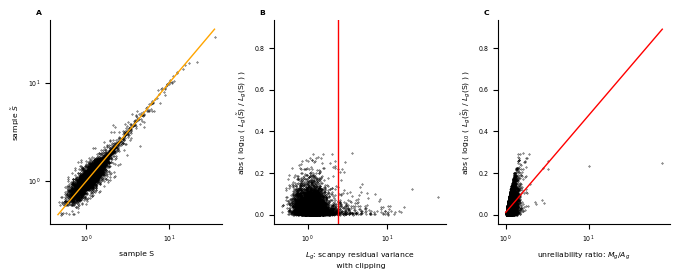

In [8]:
print ( '\n  L_g' )  
df_complementary_stats_Lg = pd.read_pickle ( Lg_complementary_dsn )  
print ( '\n\n df_complementary_stats_Lg' )
print ( '\n', df_complementary_stats_Lg )  

df_L_g_UR = pd.concat ( [ df_L_g[['stat']], df_unreliability[['unreliability']] ], axis=1 )
df_stats_Lg = df_L_g_UR.merge ( df_complementary_stats_Lg, how='inner', left_index=True, right_index=True )
pti = plot_tab ( df_stats_Lg,  "$L_g$", '$L_g$: scanpy residual variance \n with clipping', Lg_plot_dsn ) 
print ( '\n\n Table 5' )
pd.set_option('display.max_columns', 8)
print ( '\n', pti )  
pd.set_option('display.max_columns', 5)


  S_g


 df_complementary_stats_Sg

                       0         1
gene_vector                      
0610007N19RIK  0.241094  0.221250
0610007P14RIK  0.883185  0.825244
0610009B22RIK  1.083600  1.076853
0610009D07RIK  0.882407  0.821319
0610009E02RIK  0.188780  0.234825
...                 ...       ...
ZXDC           0.528365  0.514447
ZYG11B         1.089829  1.007962
ZYX            0.475080  0.480503
ZZEF1          0.920939  0.867850
ZZZ3           1.165178  1.187622

[12082 rows x 2 columns]


 genes rank_stat_200:  1.9018338893542028


                             OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.252
Model:                            OLS   Adj. R-squared:                  0.252
Method:                 Least Squares   F-statistic:                     4062.
Date:                Tue, 11 Jul 2023   Prob (F-statistic):               0.00
Time:                        08:15:44   Log-Likeliho

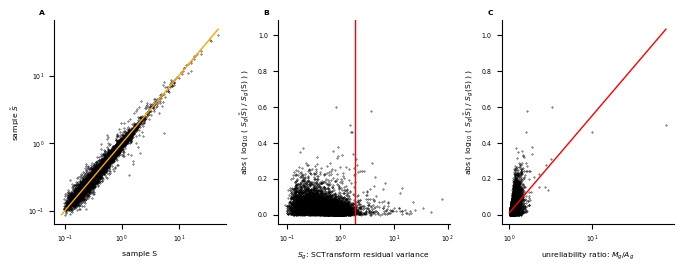

In [9]:
print ( '\n  S_g' )  
df_complementary_stats_Sg = pd.read_pickle ( Sg_complementary_dsn ).set_index ( ['gene_vector'] ).rename( columns={'0':0, '1':1 } )
print ( '\n\n df_complementary_stats_Sg' )
print ( '\n', df_complementary_stats_Sg ) 
 
df_S_g_UR = pd.concat ( [ df_S_g[['stat']], df_unreliability[['unreliability']] ], axis=1 )
df_stats_Sg = df_S_g_UR.merge ( df_complementary_stats_Sg, how='inner', left_index=True, right_index=True )
pti = plot_tab ( df_stats_Sg,  "$S_g$" , '$S_g$: SCTransform residual variance', Sg_plot_dsn ) 
print ( '\n\n Table 7' )
pd.set_option('display.max_columns', 8)
print ( '\n', pti )  
pd.set_option('display.max_columns', 5)